### correlation of AET & NDVI

In [1]:
import xarray as xr
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn

%matplotlib inline
seaborn.set_style('dark')
from scipy import stats

from scipy.stats import linregress, pearsonr, spearmanr


In [2]:
ET = xr.open_dataset('/g/data/oe9/project/team-drip/ENV_5km_month/AET_5km_month.nc')
ET_sub = ET.aet
ET_sub
# ET

<xarray.DataArray 'aet' (time: 203, latitude: 263, longitude: 280)>
[14948920 values with dtype=float64]
Coordinates:
  * time       (time) datetime64[ns] 2000-02-29 2000-03-31 2000-04-30 ...
  * latitude   (latitude) float64 -24.55 -24.6 -24.65 -24.7 -24.75 -24.8 ...
  * longitude  (longitude) float64 138.5 138.6 138.6 138.7 138.7 138.8 138.8 ...
Attributes:
    long_name:      Total evapotranspiration (sum of ee_avg and et_avg): aver...
    standard_name:  etot_avg
    units:          mm
    name:           etot_avg

In [3]:
coarse_NDVI= xr.open_dataarray('/g/data/oe9/project/team-drip/resampled_NDVI/coarse_NDVI.nc')
coarse_NDVI

<xarray.DataArray 'ndvi' (latitude: 263, longitude: 280, time: 203)>
[14948920 values with dtype=float64]
Coordinates:
  * latitude   (latitude) float64 -24.55 -24.6 -24.65 -24.7 -24.75 -24.8 ...
  * longitude  (longitude) float64 138.5 138.6 138.6 138.7 138.7 138.8 138.8 ...
  * time       (time) datetime64[ns] 2000-02-01 2000-03-01 2000-04-01 ...

In [4]:
climatology = coarse_NDVI.groupby('time.month').mean('time')
anomalies_NDVI = coarse_NDVI.groupby('time.month') - climatology
anomalies_NDVI

<xarray.DataArray 'ndvi' (latitude: 263, longitude: 280, time: 203)>
array([[[ nan,  nan, ...,  nan,  nan],
        [ nan,  nan, ...,  nan,  nan],
        ..., 
        [ nan,  nan, ...,  nan,  nan],
        [ nan,  nan, ...,  nan,  nan]],

       [[ nan,  nan, ...,  nan,  nan],
        [ nan,  nan, ...,  nan,  nan],
        ..., 
        [ nan,  nan, ...,  nan,  nan],
        [ nan,  nan, ...,  nan,  nan]],

       ..., 
       [[ nan,  nan, ...,  nan,  nan],
        [ nan,  nan, ...,  nan,  nan],
        ..., 
        [ nan,  nan, ...,  nan,  nan],
        [ nan,  nan, ...,  nan,  nan]],

       [[ nan,  nan, ...,  nan,  nan],
        [ nan,  nan, ...,  nan,  nan],
        ..., 
        [ nan,  nan, ...,  nan,  nan],
        [ nan,  nan, ...,  nan,  nan]]])
Coordinates:
  * latitude   (latitude) float64 -24.55 -24.6 -24.65 -24.7 -24.75 -24.8 ...
  * longitude  (longitude) float64 138.5 138.6 138.6 138.7 138.7 138.8 138.8 ...
  * time       (time) datetime64[ns] 2000-02-01 2000-03-01 

In [5]:
# Start by setting up a new dataset, with empty arrays along latitude and longitude
dims = ('latitude', 'longitude')
coords = {d: ET_sub[d] for d in dims}
correlation_data = {
    name: xr.DataArray(data=np.ndarray([len(ET_sub[d]) for d in dims]),
                       name=name, dims=dims)
    for name in 'pearson_r pearson_p spearman_r spearman_p'.split()
}
corr_1M_ET_NDVI = xr.Dataset(data_vars=correlation_data, coords=coords)
corr_1M_ET_NDVI


<xarray.Dataset>
Dimensions:     (latitude: 263, longitude: 280)
Coordinates:
  * latitude    (latitude) float64 -24.55 -24.6 -24.65 -24.7 -24.75 -24.8 ...
  * longitude   (longitude) float64 138.5 138.6 138.6 138.7 138.7 138.8 ...
Data variables:
    pearson_r   (latitude, longitude) float64 2.743e-316 6.944e-310 ...
    pearson_p   (latitude, longitude) float64 6.944e-310 6.944e-310 0.0 0.0 ...
    spearman_r  (latitude, longitude) float64 2.773e-316 6.944e-310 ...
    spearman_p  (latitude, longitude) float64 nan nan nan nan nan nan nan ...

In [7]:
ET_sub.isel(latitude=3)


<xarray.DataArray 'aet' (time: 203, longitude: 280)>
array([[ nan,  nan,  nan, ...,  nan,  nan,  nan],
       [ nan,  nan,  nan, ...,  nan,  nan,  nan],
       [ nan,  nan,  nan, ...,  nan,  nan,  nan],
       ..., 
       [ nan,  nan,  nan, ...,  nan,  nan,  nan],
       [ nan,  nan,  nan, ...,  nan,  nan,  nan],
       [ nan,  nan,  nan, ...,  nan,  nan,  nan]])
Coordinates:
  * time       (time) datetime64[ns] 2000-02-29 2000-03-31 2000-04-30 ...
    latitude   float64 -24.7
  * longitude  (longitude) float64 138.5 138.6 138.6 138.7 138.7 138.8 138.8 ...
Attributes:
    long_name:      Total evapotranspiration (sum of ee_avg and et_avg): aver...
    standard_name:  etot_avg
    units:          mm
    name:           etot_avg

In [8]:
%%time
# By looping, we make a list of lists of correlations
latout = []
for ind_lat, lat in enumerate(anomalies_NDVI.latitude):
    lonout = []
    latout.append(lonout)
    for ind_lon, lon in enumerate(anomalies_NDVI.longitude):
        NDVI = anomalies_NDVI.sel(latitude=lat, longitude=lon)
#         SPI = spi_1M_sub.sel(latitude=lat, longitude=lon)
        ET = ET_sub.isel(latitude=ind_lat, longitude=ind_lon)
#         mask = ~np.isinf(ET)
#         subset_NDVI= NDVI.where(mask, drop=True)
#         subset_SPI= ET.where(mask, drop=True)
        
        val = pearsonr(NDVI,ET)
        try:
            # Spearman's R can fail for some values
            val += spearmanr(NDVI,ET)
        except ValueError:
            val += (np.nan, np.nan)
        lonout.append(val)
# Then we convert the lists to an array
arr = np.array(latout)
# And finally insert the pieces into our correlation dataset
corr_1M_ET_NDVI.pearson_r[:] = arr[..., 0]
corr_1M_ET_NDVI.pearson_p[:] = arr[..., 1]
corr_1M_ET_NDVI.spearman_r[:] = arr[..., 2]
corr_1M_ET_NDVI.spearman_p[:] = arr[..., 3]

/g/data/v10/public/modules/agdc-py3-env/20171214/envs/agdc/lib/python3.6/site-packages/scipy/stats/stats.py:3003: RuntimeWarning: invalid value encountered in double_scalars
  r = r_num / r_den
/g/data/v10/public/modules/agdc-py3-env/20171214/envs/agdc/lib/python3.6/site-packages/numpy/lib/function_base.py:3167: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/g/data/v10/public/modules/agdc-py3-env/20171214/envs/agdc/lib/python3.6/site-packages/numpy/lib/function_base.py:3168: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/g/data/v10/public/modules/agdc-py3-env/20171214/envs/agdc/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/g/data/v10/public/modules/agdc-py3-env/20171214/envs/agdc/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return

CPU times: user 5min 27s, sys: 1min 57s, total: 7min 25s
Wall time: 7min 26s


In [15]:
corr_1M_ET_NDVI

<xarray.Dataset>
Dimensions:     (latitude: 263, longitude: 280)
Coordinates:
  * latitude    (latitude) float64 -24.55 -24.6 -24.65 -24.7 -24.75 -24.8 ...
  * longitude   (longitude) float64 138.5 138.6 138.6 138.7 138.7 138.8 ...
Data variables:
    pearson_r   (latitude, longitude) float64 nan nan nan nan nan nan nan ...
    pearson_p   (latitude, longitude) float64 1.0 1.0 1.0 1.0 1.0 1.0 1.0 ...
    spearman_r  (latitude, longitude) float64 nan nan nan nan nan nan nan ...
    spearman_p  (latitude, longitude) float64 nan nan nan nan nan nan nan ...

### save correlation to NC

In [20]:
outpath = '/g/data/oe9/project/team-drip/Spatial_temporal_correlation/AET_NDVI.nc'
corr_1M_ET_NDVI.to_netcdf(outpath, mode = 'w')

### plot the correlation map

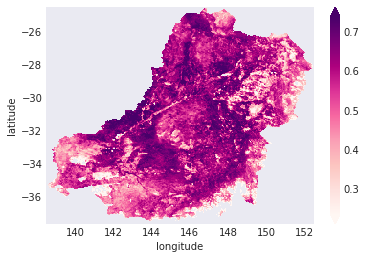

In [19]:
SIGNIFICANT = 0.05  # Choose your own!
corr_1M_ET_NDVI.pearson_r.where(corr_1M_ET_NDVI.pearson_p < 0.05).plot.imshow(robust=True,cmap = 'RdPu')


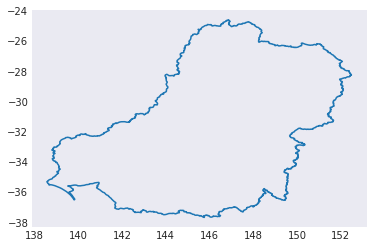

In [21]:
# import fiona
import shapefile   

shpFilePath = '/g/data/oe9/project/team-drip/MDB_shapefile/mdb_boundary/mdb_boundary.shp' 
listx=[]
listy=[]
test = shapefile.Reader(shpFilePath)
for sr in test.shapeRecords():
    for xNew,yNew in sr.shape.points:
        listx.append(xNew)
        listy.append(yNew)
plt.plot(listx,listy)
plt.show()

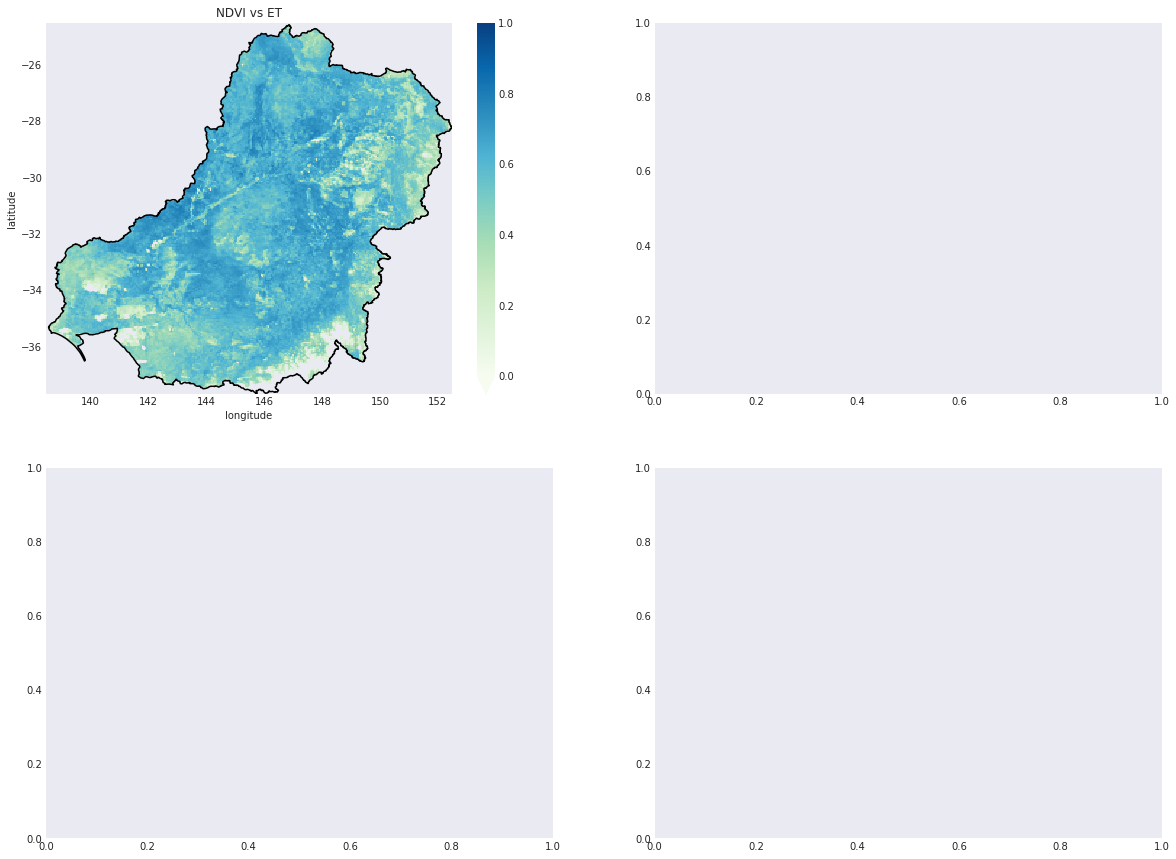

In [31]:
# # Create a figure with several subplots - three columns
figure, ax_s = plt.subplots(nrows = 2,ncols = 2,figsize=(20, 15))
# plt.title('Correlation between NDVI and SPI')


corr_1M_ET_NDVI.pearson_r.where(corr_1M_ET_NDVI.pearson_p < 0.05).plot.imshow(ax = ax_s[0,0],
                                                              robust=True, cmap='GnBu', vmin=0.0, vmax=1.0)
ax_s[0,0].plot(listx,listy,color='black')
ax_s[0,0].set_title('NDVI vs ET')

cbr = figure.colorbar